### I am planning to use Long Short Term Memory Network (LSTM) for building Machine Learning model to predict the stock prices of any given stock, in this excercise i am taking apple stock as an example. LSTM is one of the best suited model for time series data like stock price.

### Importing all the required python libraries

In [ ]:

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [36]:
apple_df =pd.read_csv('apple.csv')
df = apple_df[['Date', 'Close']]
print(df)

             Date       Close
0      1980-12-12    0.128348
1      1980-12-15    0.121652
2      1980-12-16    0.112723
3      1980-12-17    0.115513
4      1980-12-18    0.118862
...           ...         ...
10501  2022-08-08  164.869995
10502  2022-08-09  164.919998
10503  2022-08-10  169.240005
10504  2022-08-11  168.490005
10505  2022-08-12  172.100006

[10506 rows x 2 columns]


<AxesSubplot:xlabel='Date'>

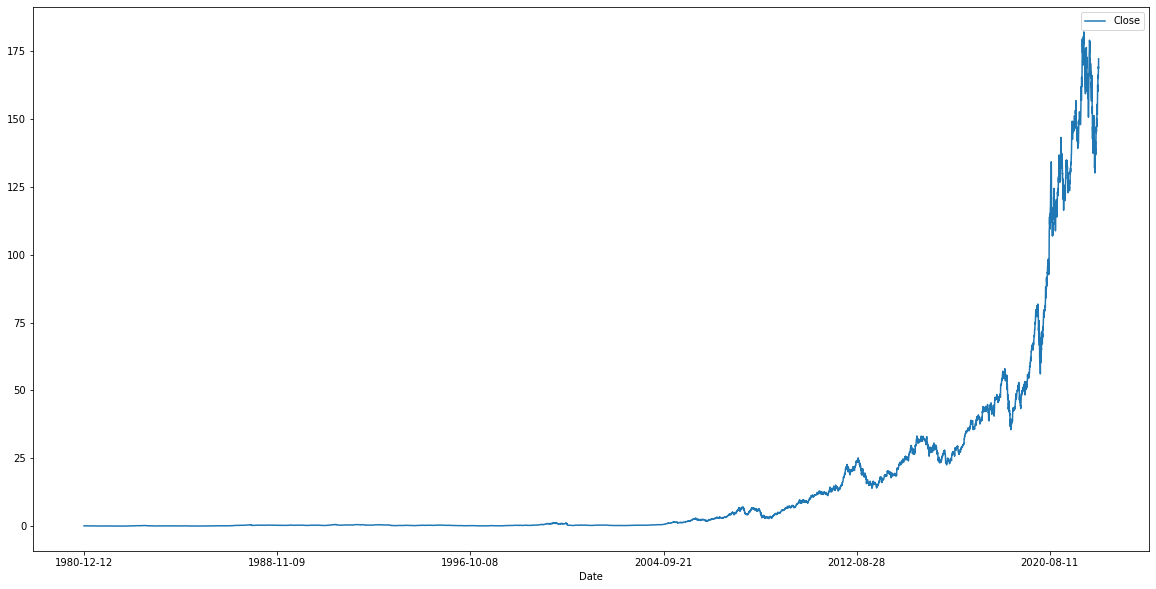

In [37]:
#Plotting closing price of the apple stock
df.plot.line(y="Close",x="Date")

In [38]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [39]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

C:\Users\SasiH\AppData\Local\Temp/ipykernel_25736/2565755782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0       1980-12-12
1       1980-12-15
2       1980-12-16
3       1980-12-17
4       1980-12-18
           ...    
10501   2022-08-08
10502   2022-08-09
10503   2022-08-10
10504   2022-08-11
10505   2022-08-12
Name: Date, Length: 10506, dtype: datetime64[ns]

In [40]:
df.index = df.pop('Date')
df

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862
...,...
2022-08-08,164.869995
2022-08-09,164.919998
2022-08-10,169.240005


In [42]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-08-12', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,123.389999,122.540001,120.089996,120.589996
1,2021-03-26,122.540001,120.089996,120.589996,121.209999
2,2021-03-29,120.089996,120.589996,121.209999,121.389999
3,2021-03-30,120.589996,121.209999,121.389999,119.900002
4,2021-03-31,121.209999,121.389999,119.900002,122.150002
...,...,...,...,...,...
345,2022-08-08,166.130005,165.809998,165.350006,164.869995
346,2022-08-09,165.809998,165.350006,164.869995,164.919998
347,2022-08-10,165.350006,164.869995,164.919998,169.240005
348,2022-08-11,164.869995,164.919998,169.240005,168.490005


In [43]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((350,), (350, 3, 1), (350,))

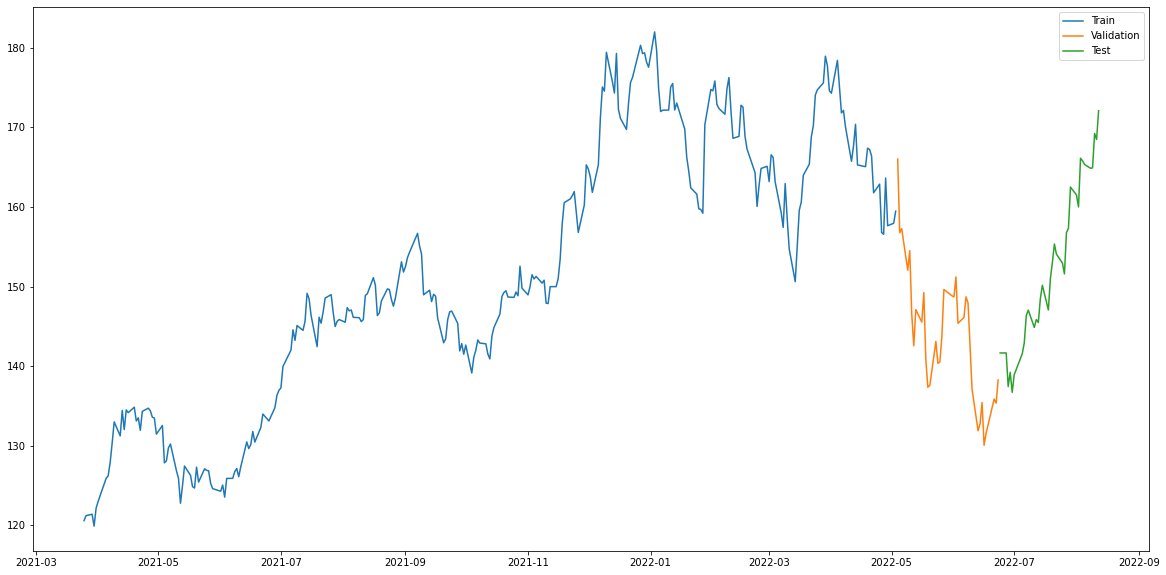

In [44]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
9/9 [==============================] - 5s 80ms/step - loss: 23169.1660 - mean_absolute_error: 151.3121 - val_loss: 20705.0000 - val_mean_absolute_error: 143.6676
Epoch 2/100
9/9 [==============================] - 0s 9ms/step - loss: 23059.7363 - mean_absolute_error: 150.9509 - val_loss: 20613.8203 - val_mean_absolute_error: 143.3499
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 22950.6543 - mean_absolute_error: 150.5892 - val_loss: 20494.6973 - val_mean_absolute_error: 142.9338
Epoch 4/100
9/9 [==============================] - 0s 9ms/step - loss: 22806.0039 - mean_absolute_error: 150.1066 - val_loss: 20306.7031 - val_mean_absolute_error: 142.2743
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: 22532.4590 - mean_absolute_error: 149.1893 - val_loss: 19938.3613 - val_mean_absolute_error: 140.9737
Epoch 6/100
9/9 [==============================] - 0s 8ms/step - loss: 22054.6074 - mean_absolute_error: 147.5800 - val_loss: 19378.63

9/9 [==============================] - 1s 5ms/step


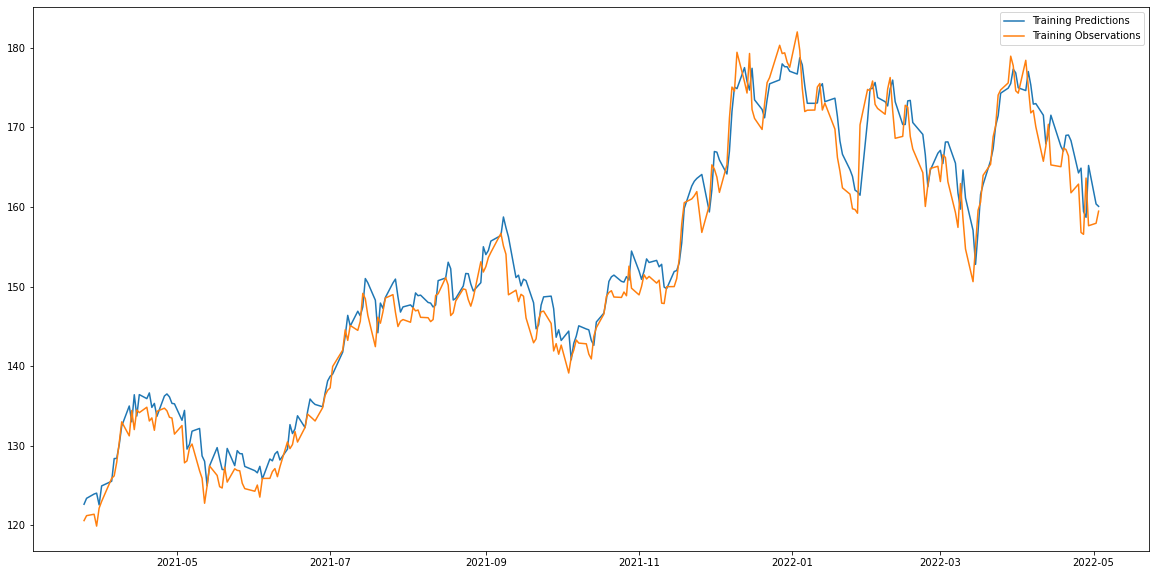

In [46]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 3ms/step


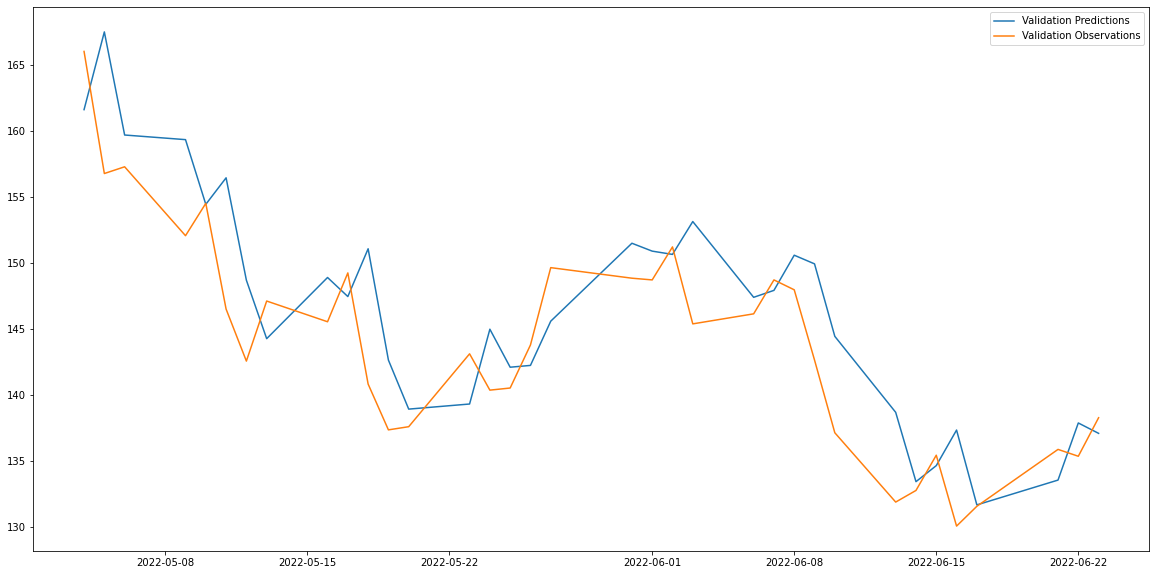

In [47]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 3ms/step


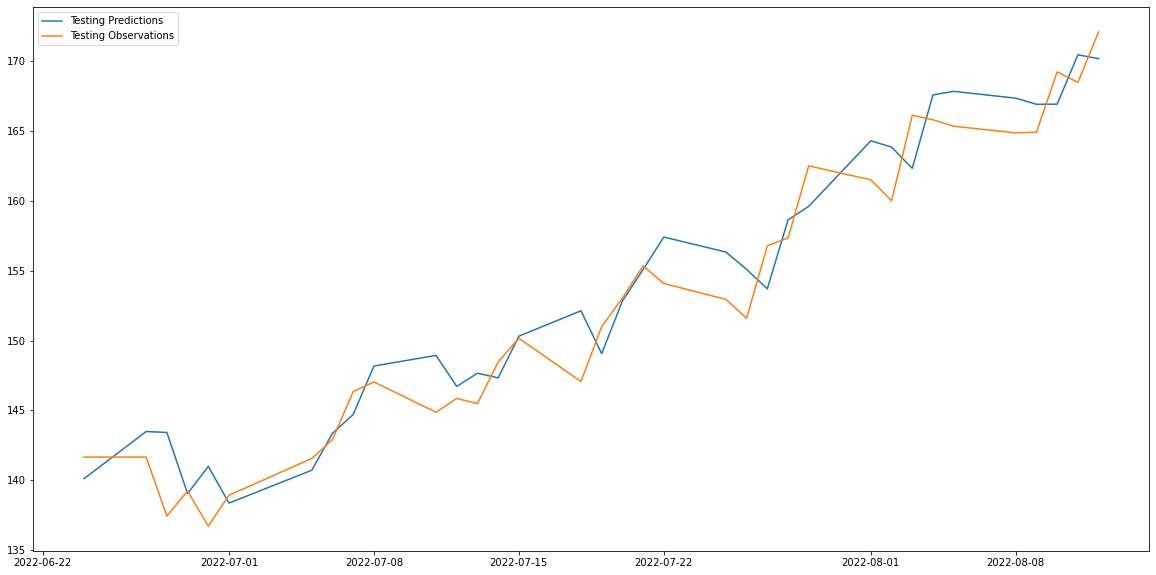

In [48]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

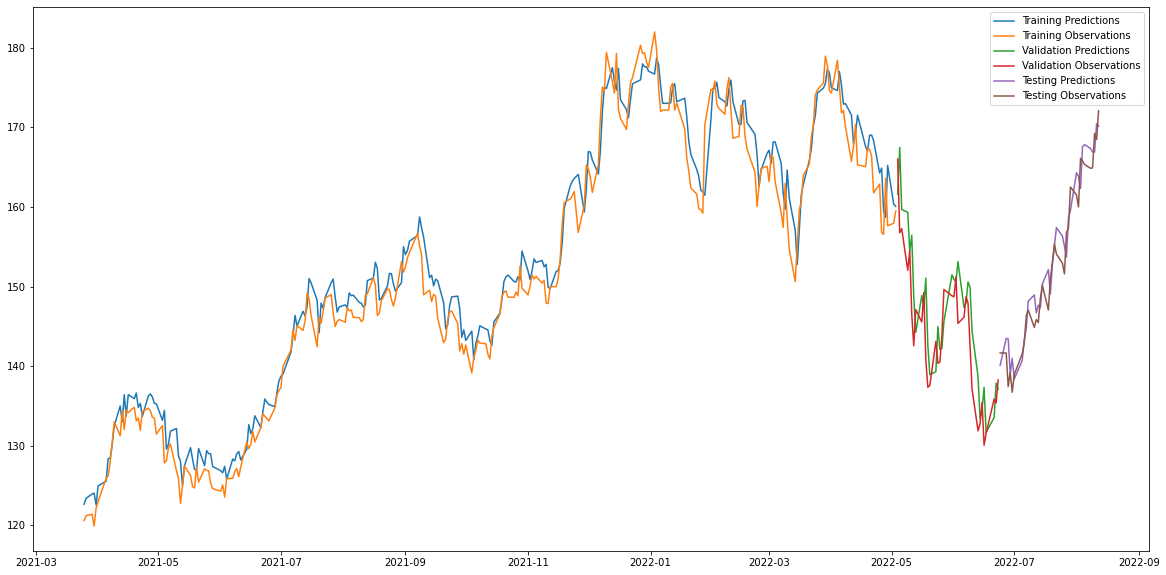

In [49]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [50]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 16ms/step


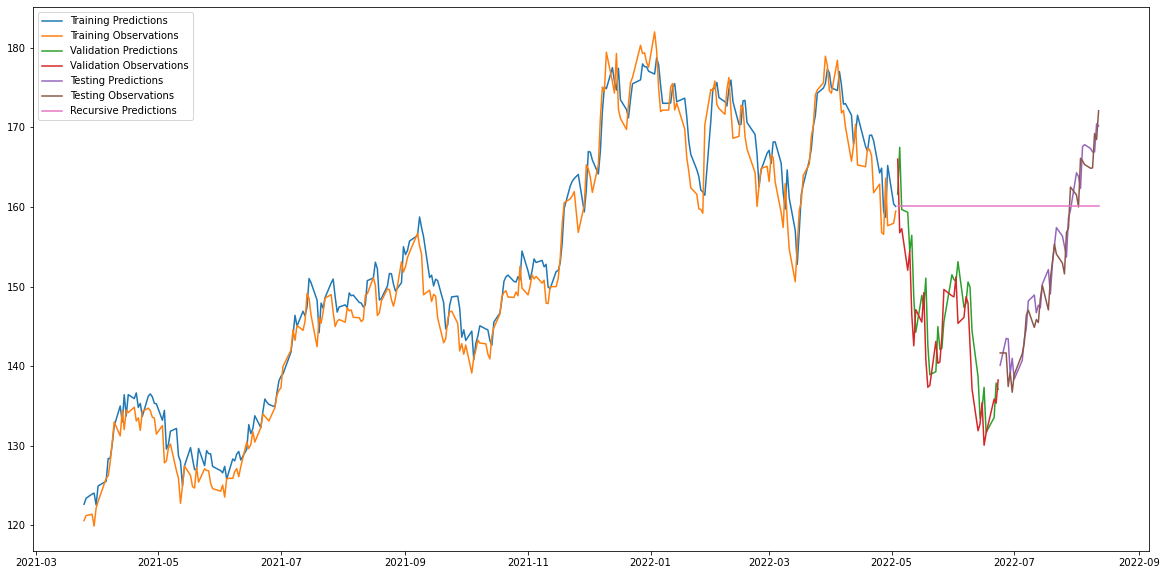

In [51]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])